# ML in Cybersecurity: Task II

## Team
  * **Team name**:  ESS
  * **Members**:  Eiram Mahera Sheikh (eish00001@stud.uni-saarland.de), Shravan Swaminathan(shsw00001@stud.uni-saarland.de), Shayari Bhattacharjee(shbh00002@stud.uni-saarland.de)


## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [ ]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [ ]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

np.random.seed(200)

In [ ]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [ ]:
undefended_model_path = "undefended_model.pth"
defended_model_path = "defended_model.pth"

# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1
learning_rate_1 = 0.01
learning_rate_2=  0.05
momentum_1 = 0.5
momentum_2 = 0.25

log_interval = 10

In [ ]:
# (1)load data 
#torchvision dataloaders to download MNIST dataset.
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root = './data', train = [True, False], transform = transform, download=True)
trainSet, testSet = torch.utils.data.random_split(dataset, [50000, 10000])

train_loader = data.DataLoader(trainSet, batch_size=batch_size_train, shuffle=True)
test_loader  = data.DataLoader(testSet, batch_size=batch_size_test, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# (2)define model
# Model with no dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)



network = Net().to(device)
optimizer4 = optim.SGD(network.parameters(), lr=learning_rate_2,momentum=momentum_2)

In [ ]:
#defining list to save training and testing loss for future evaluation.
train_losses = []
train_counter = []
test_losses = []
#test_counter_4 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)] todo - clean up
train_acc = []
test_acc = []

# (3)define loss, optimizer 
#Training function for all networks
def train(epoch):
  network.train()
  correct = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer4.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer4.step()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
    if batch_idx % log_interval == 0:
      print('Network:Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), "model.pth")
      #torch.save(optimizer4.state_dict(), "model.pth")
      torch.save(network.state_dict(), undefended_model_path)
  accuracy = 100 * correct / len(train_loader.dataset)
  train_acc.append(accuracy)
  print("Accuracy = {}".format(accuracy))
  

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  
  accuracy= correct/len(test_loader.dataset)
  test_acc.append(accuracy)
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\n Network: Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [ ]:
# (4)train (You can re-use the trained model from project1)
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Network:Train Epoch: 1 [0/50000 (0%)]	Loss: 2.316428
Network:Train Epoch: 1 [640/50000 (1%)]	Loss: 2.305497
Network:Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.280816
Network:Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.289466
Network:Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.299625
Network:Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.283566
Network:Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.265514
Network:Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.282890
Network:Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.243161
Network:Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.200317
Network:Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.124317
Network:Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.993416
Network:Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.716087
Network:Train Epoch: 1 [8320/50000 (17%)]	Loss: 1.550713
Network:Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.299339
Network:Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.162595
Network:Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.049349
Network:Train Epoch: 1 [10880/50000 (22%)]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 Network: Test set: Avg. loss: 0.1990, Accuracy: 9387/10000 (94%)

Network:Train Epoch: 2 [0/50000 (0%)]	Loss: 0.590047
Network:Train Epoch: 2 [640/50000 (1%)]	Loss: 0.388359
Network:Train Epoch: 2 [1280/50000 (3%)]	Loss: 0.291997
Network:Train Epoch: 2 [1920/50000 (4%)]	Loss: 0.511011
Network:Train Epoch: 2 [2560/50000 (5%)]	Loss: 0.334798
Network:Train Epoch: 2 [3200/50000 (6%)]	Loss: 0.441801
Network:Train Epoch: 2 [3840/50000 (8%)]	Loss: 0.530960
Network:Train Epoch: 2 [4480/50000 (9%)]	Loss: 0.270320
Network:Train Epoch: 2 [5120/50000 (10%)]	Loss: 0.344531
Network:Train Epoch: 2 [5760/50000 (12%)]	Loss: 0.455211
Network:Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.826726
Network:Train Epoch: 2 [7040/50000 (14%)]	Loss: 0.494780
Network:Train Epoch: 2 [7680/50000 (15%)]	Loss: 0.466330
Network:Train Epoch: 2 [8320/50000 (17%)]	Loss: 0.329227
Network:Train Epoch: 2 [8960/50000 (18%)]	Loss: 0.474129
Network:Train Epoch: 2 [9600/50000 (19%)]	Loss: 0.242329
Network:Train Epoch: 2 [10240/50

In [ ]:
# (5)evaluate
for epoch in range(1, n_epochs + 1):  
  print('Epoch %d, Train Accuracy: %f, Test Accuracy: %f' % (epoch, train_acc[epoch-1], test_acc[epoch-1]))

Epoch 1, Train Accuracy: 70.353996, Test Accuracy: 0.938700
Epoch 2, Train Accuracy: 89.120003, Test Accuracy: 0.959200
Epoch 3, Train Accuracy: 91.533997, Test Accuracy: 0.965400


## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


**Note for Shravan**

**def fgsm_attack(model, x, y, epsilon)**

**The function must return a perturbed image** 

*Hints obtained from tutorial* - **Do not clean up**


*   *Fast gradient sign method attack - optimised to have fast calculation*
*   *Cross entropy loss - gradient of the function*
*   *Computing the gradient of the loss function that we've used to train the model. Instead of computing the gradient wrt to the training paramters in order to reduce the loss.*
*   *Epsilon is the perturbation budget. Degree to which you want to influence the image. *
*   *Compute the epsilon times the signed gradient of the cost function and add it to the image.* 
*   *To preserve the range of the image in [0,1], the pixels need to be clipped (torch function available?)*
*   *Computing gradient in pytorch is quite easy by enabling "required gradient".*
*   *Normal forward path to compute the loss and then do backward automatic differentiation of the loss function to get the gradient of the image. *
*   *1.2 shall have a function to compute the attack. This shall be called from 1.3*

*Notes from paper*
*η = Epsilon * sign (∇xJ(θ, x, y)).*





In [ ]:
def fastGradSignAttack(epsilon, model, dataSet, dictPerturbedImage={}, dictRuntimeMeasurement={}):
  dictPerturbedImage[epsilon] = []
  dictRuntimeMeasurement[epsilon] = 0
  for data, originalLabel in dataSet:
    data, originalLabel = data.to(device), originalLabel.to(device) 
    data.requires_grad = True  #Enabling PyTorch gradient (hint from tutorial)
    # Predicting before attacking image
    output = model(data)
    predBeforeAttack = output.max(1, keepdim=True)[1]
    perturbedImage = data # Initializing perturbedImage to input image data in case initialial prediction fails. 

    # Establishing a point of reference. Evaluating prediction after attack makes sense only when the prediction before the attack is correct.
    if predBeforeAttack.item() == originalLabel.item():
      #---------------------------------------#
      #Start of run-time measurement
      start = time.perf_counter()
      #---------------------------------------#
      #Normal forward path to compute the loss and then do backward automatic differentiation of the loss function to get the gradient of the image. (hint from tutorial)
      loss = F.nll_loss(output, originalLabel, size_average=False)
      model.zero_grad()
      loss.backward()
      
      #---------------------------------------#
      #η = Epsilon * sign (∇xJ(θ, x, y)).

      # sign (∇xJ(θ, x, y))      
      
      signedGradient = (data.grad.data).sign()

      #η = Epsilon * sign (∇xJ(θ, x, y)).
      perturbedImage = torch.clamp(data + epsilon*signedGradient, 0, 1) #clipping image additionally (hint from tutorial)
      #---------------------------------------#
      #End of run-time measurement
      end = time.perf_counter()
      #---------------------------------------#

      
      dictRuntimeMeasurement[epsilon] += end-start

      dictPerturbedImage[epsilon].append((data, perturbedImage, originalLabel)) # perturbedImage.squeeze().detach().cpu().numpy()

  dictRuntimeMeasurement[epsilon] = dictRuntimeMeasurement[epsilon]/ len(dictPerturbedImage[epsilon])

  return perturbedImage #This return value makes sense only when dataSet is a single entry (used in case of I-FGSM)


def fastGradSignAttackAccuracy(epsilon, model, perturbedImageSet, dictSuccessfulAttack, dictAfterAttackAccuracy):
  positivePredCntr = 0
  for originalImage, perturbedImage, originalLabel in perturbedImageSet[epsilon]:
    # Predicting with the attacked image
    predAfterAttack = model(perturbedImage)
    predLabel = predAfterAttack.data.max(1, keepdim=True)[1]

    if predLabel.item() != originalLabel.item():
      dictSuccessfulAttack[epsilon].append((originalImage, perturbedImage.squeeze().detach().cpu().numpy(), originalLabel, predLabel))
    else:
      #prediction is correct despite attack
      positivePredCntr += 1
    #---------------------------------------#

  #Attack accuracy measurement
  accuracyAfterAttack = positivePredCntr/float(len(perturbedImageSet[epsilon]))
  dictAfterAttackAccuracy[epsilon] = accuracyAfterAttack

  print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, accuracyAfterAttack*100))
  
  return 



## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [ ]:
def initDictPerturbedImage(epsilon, dictArg):
    dictArg[epsilon] = []

In [ ]:
epsilons =  np.arange(0.05, 1, 0.05).tolist()
epsilons = [round(epsilon, 2) for epsilon in epsilons]

In [ ]:
dictPerturbedImage_org = {}
dictAfterAttackAccuracy_org = {}
dictRuntimeMeasurement_org = {}
dictSuccessfulAttack_org = {}

# load the undefended model
undefendedModel = Net().to(device)
undefendedModel.load_state_dict(torch.load(undefended_model_path))
undefendedModel.eval()

for eps in epsilons:
  #initDictPerturbedImage(eps, dictPerturbedImage_org)
  
  fastGradSignAttack(eps, undefendedModel, test_loader, dictPerturbedImage_org, dictRuntimeMeasurement_org)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
for eps in epsilons:
  initDictPerturbedImage(eps, dictSuccessfulAttack_org)
  fastGradSignAttackAccuracy(eps, undefendedModel, dictPerturbedImage_org, dictSuccessfulAttack_org, dictAfterAttackAccuracy_org)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0.05	Test Accuracy = 93.85301129884938
Epsilon: 0.1	Test Accuracy = 82.6578210842749
Epsilon: 0.15	Test Accuracy = 64.28941639888049
Epsilon: 0.2	Test Accuracy = 40.20939152068001
Epsilon: 0.25	Test Accuracy = 18.648284440758786
Epsilon: 0.3	Test Accuracy = 7.411630558722919
Epsilon: 0.35	Test Accuracy = 3.0786773090079818
Epsilon: 0.4	Test Accuracy = 1.6481807815901317
Epsilon: 0.45	Test Accuracy = 1.0987871877267545
Epsilon: 0.5	Test Accuracy = 0.8292733492277392
Epsilon: 0.55	Test Accuracy = 0.7670778480356587
Epsilon: 0.6	Test Accuracy = 0.798175598631699
Epsilon: 0.65	Test Accuracy = 0.9847621022079404
Epsilon: 0.7	Test Accuracy = 1.119519021457448
Epsilon: 0.75	Test Accuracy = 1.3475691924950761
Epsilon: 0.8	Test Accuracy = 1.5237897792059707
Epsilon: 0.85	Test Accuracy = 1.9487923706851868
Epsilon: 0.9	Test Accuracy = 2.363429045299057
Epsilon: 0.95	Test Accuracy = 2.757333886182233


In [ ]:
for eps in epsilons:
  print("Epsilon: {}\t Run-time: {} ms".format(eps, dictRuntimeMeasurement_org[eps]*1000))
  

Epsilon: 0.05	 Run-time: 1.0834377453000117 ms
Epsilon: 0.1	 Run-time: 1.0856275581009867 ms
Epsilon: 0.15	 Run-time: 1.0981591980999836 ms
Epsilon: 0.2	 Run-time: 1.0859594478992676 ms
Epsilon: 0.25	 Run-time: 1.0899853783009348 ms
Epsilon: 0.3	 Run-time: 1.073570753900822 ms
Epsilon: 0.35	 Run-time: 1.1018912854006886 ms
Epsilon: 0.4	 Run-time: 1.1856669848992396 ms
Epsilon: 0.45	 Run-time: 1.1362156922984694 ms
Epsilon: 0.5	 Run-time: 1.1132098579010972 ms
Epsilon: 0.55	 Run-time: 1.1079315486997756 ms
Epsilon: 0.6	 Run-time: 1.1796200463991453 ms
Epsilon: 0.65	 Run-time: 1.128939592999336 ms
Epsilon: 0.7	 Run-time: 1.1105595716006746 ms
Epsilon: 0.75	 Run-time: 1.1627599207996582 ms
Epsilon: 0.8	 Run-time: 1.115660467098951 ms
Epsilon: 0.85	 Run-time: 1.0863315136002256 ms
Epsilon: 0.9	 Run-time: 1.084264512099776 ms
Epsilon: 0.95	 Run-time: 1.1445245619028128 ms


In [ ]:
EPSILON_SMALL_BUDGET_IDX = 0
EPSILON_MIDDLE_BUDGET_IDX = 1
EPSILON_LARGE_BUDGET_IDX = 2
 
epsilon3Fild = [0.10,0.15,0.20] #choosing at random 3 perturbation budgets at random with more than 1000 adversarial samples

#1000 adversarial samples for each perturbation budget. More samples are generated however only 1000 are used below (question says atleast 1000 therefore this should be okay)
advSampleSmallPertBudget = dictSuccessfulAttack_org[epsilon3Fild[EPSILON_SMALL_BUDGET_IDX]][:1000]
advSampleMiddlePertBudget = dictSuccessfulAttack_org[epsilon3Fild[EPSILON_MIDDLE_BUDGET_IDX]][:1000]
advSampleLargePertBudget = dictSuccessfulAttack_org[epsilon3Fild[EPSILON_LARGE_BUDGET_IDX]][:1000]


## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

In [ ]:

def findNextLabelIdx(labelValue, searchTensor):
  idxList = list(range(len(searchTensor)))
  searchList = [x[2] for x in searchTensor]

  for idx in idxList:
    if searchList[idx] == labelValue:
      return idx


def plotForEpsilon(epsilon, advSampleList):
  col_titles = ['Original Image','FGSM Perturbed Image'] 
  nsamples = 11
  nrows = nsamples
  ncols = len(col_titles)

  fig, axes = plt.subplots(nrows,ncols,figsize=(10,15))  # create the figure with subplots
  [ax.set_axis_off() for ax in axes.ravel()]  # remove the axis


  for ax, col in zip(axes[0], col_titles): # set up the title for each column
      ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

  for i in range(nsamples):
    if(i != 0):
      data_original, data_attacked, label_original, label_attacked = advSampleList[findNextLabelIdx(i-1, advSampleList)]
      im_original = torchvision.utils.make_grid(data_original)
      im_original = torch.clamp(im_original, 0, 1)

      axes[i,0].imshow(np.transpose(im_original.numpy(), (1, 2, 0)))  
      axes[i,1].imshow(data_attacked)

      axes[i][0].title.set_text('Label - {}'.format(label_original.numpy()[0]))
      axes[i][1].title.set_text('Pred. Label - {}'.format(label_attacked.numpy()[0][0]))

  fig.suptitle("Epsilon - {}".format(epsilon, fontdict={'fontsize':18,'color':'b'}))
  fig.subplots_adjust(top=0.88)
  fig.tight_layout()
    


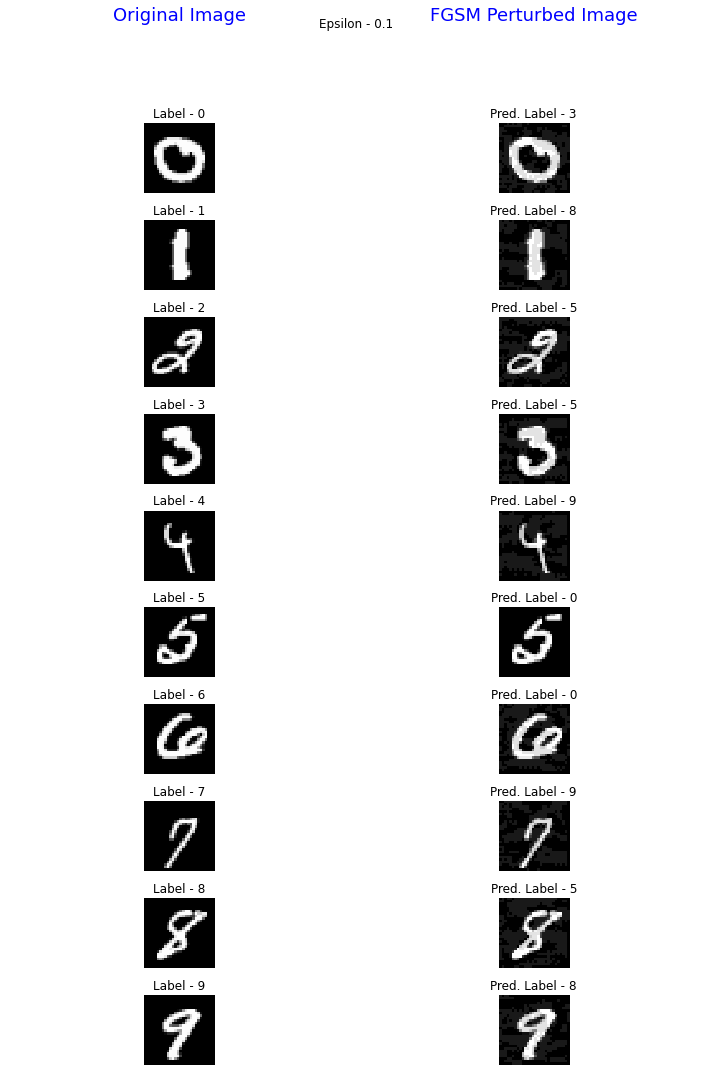

In [ ]:
plotForEpsilon(epsilon3Fild[EPSILON_SMALL_BUDGET_IDX], advSampleSmallPertBudget)

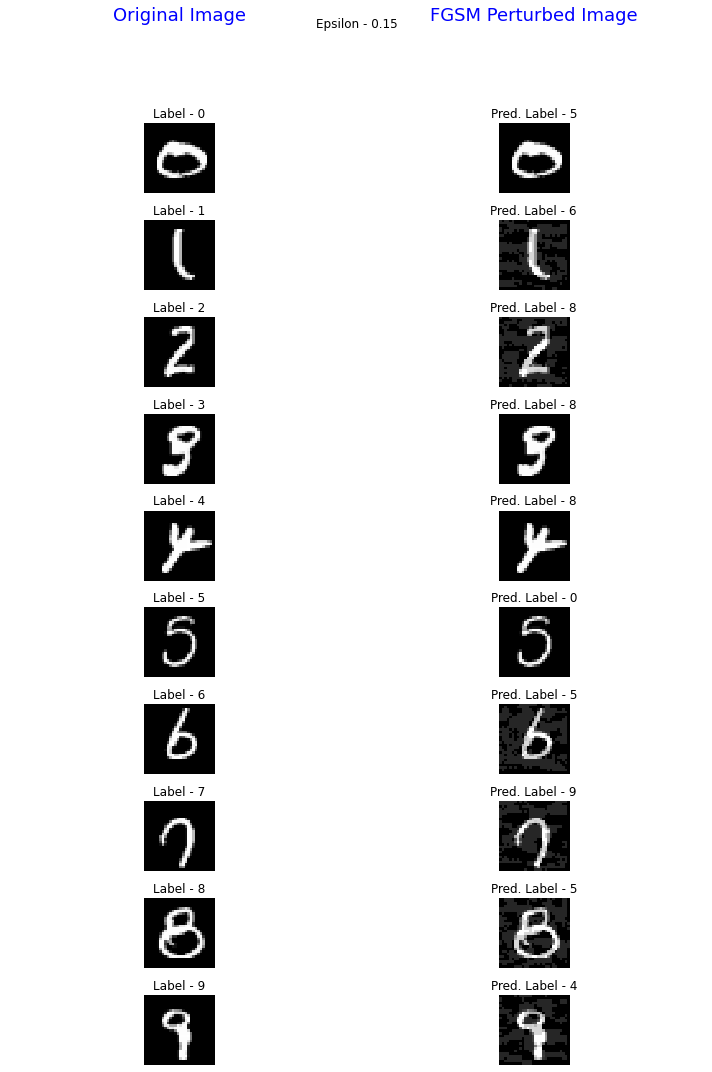

In [ ]:
plotForEpsilon(epsilon3Fild[EPSILON_MIDDLE_BUDGET_IDX], advSampleMiddlePertBudget)

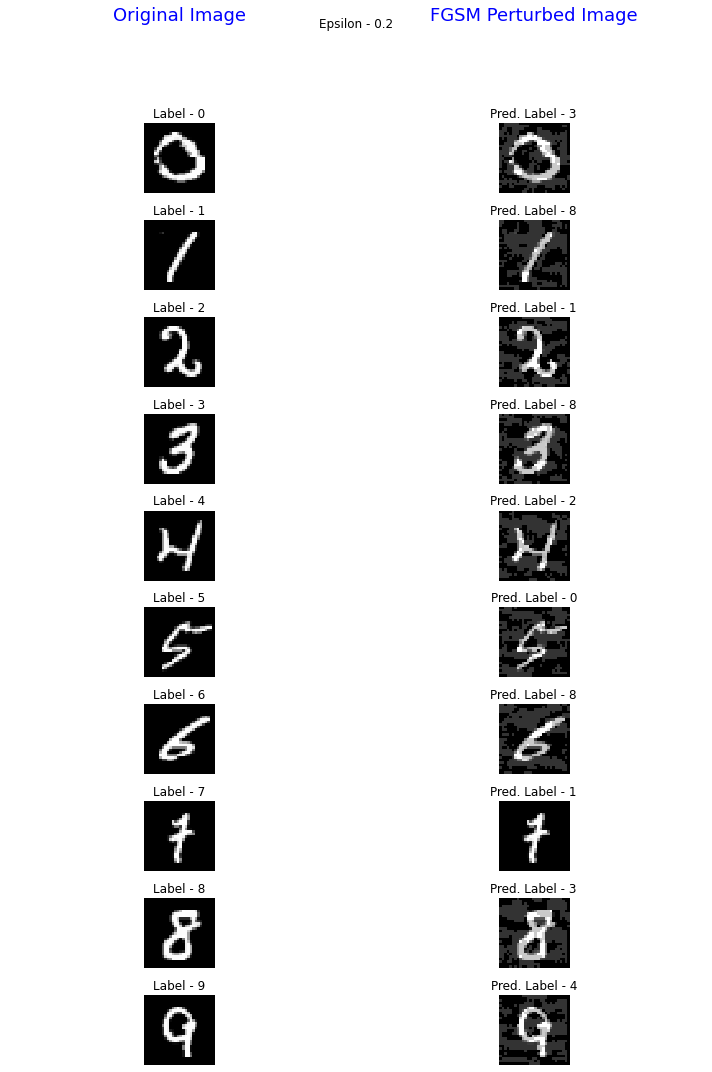

In [ ]:
plotForEpsilon(epsilon3Fild[EPSILON_LARGE_BUDGET_IDX], advSampleLargePertBudget)

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations 




**ANSWERS**


Q:  Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?

A: The attack doesn't always succeed from the stand point that there is a non-zero amount of image that the model classifies correctly for any given value of epsilon < 0.95. Even at Epsilon = 0.95, the model has a 5% accuracy which means the attack doesn't "always" succeed. The analysis was done for a wide range of perturbation budgets(Epsilon) and the success of the attack was greater for larger perturbation budgets as one might guess. For a value of Epsilon as small as 0.05, the model was still able to predict with about 90% accuracy however for slightly higher values of epsilon such as 0.25 or 0.35, the accuracy already drops to a staggering low 75% and 50% respectively. 

Below, you'll find 2 sets outputs of test accuracy

*   Set 1 - The 3 chosen perturbation budgets and their accuracies
*   Set 2 - The whole range of perturbation budgets explored and their accuracies







In [ ]:
for eps in epsilon3Fild:
  print("Epsilon: {}\tTest Accuracy = {}".format(eps, dictAfterAttackAccuracy_org[eps]))

Epsilon: 0.1	Test Accuracy = 0.7974
Epsilon: 0.15	Test Accuracy = 0.6202
Epsilon: 0.2	Test Accuracy = 0.3879


In [ ]:
for eps in epsilons:
  print("Epsilon: {}\tTest Accuracy = {}".format(eps, dictAfterAttackAccuracy_org[eps]*100))

Epsilon: 0.05	Test Accuracy = 90.53999999999999
Epsilon: 0.1	Test Accuracy = 79.74
Epsilon: 0.15	Test Accuracy = 62.019999999999996
Epsilon: 0.2	Test Accuracy = 38.79
Epsilon: 0.25	Test Accuracy = 17.990000000000002
Epsilon: 0.3	Test Accuracy = 7.1499999999999995
Epsilon: 0.35	Test Accuracy = 2.97
Epsilon: 0.4	Test Accuracy = 1.59
Epsilon: 0.45	Test Accuracy = 1.06
Epsilon: 0.5	Test Accuracy = 0.8
Epsilon: 0.55	Test Accuracy = 0.74
Epsilon: 0.6	Test Accuracy = 0.77
Epsilon: 0.65	Test Accuracy = 0.95
Epsilon: 0.7	Test Accuracy = 1.08
Epsilon: 0.75	Test Accuracy = 1.3
Epsilon: 0.8	Test Accuracy = 1.47
Epsilon: 0.85	Test Accuracy = 1.8800000000000001
Epsilon: 0.9	Test Accuracy = 2.2800000000000002
Epsilon: 0.95	Test Accuracy = 2.6599999999999997


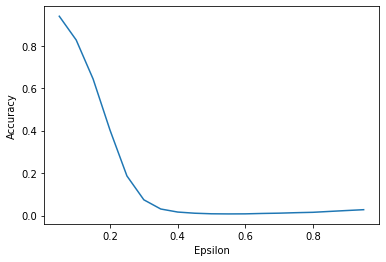

In [ ]:
lists = sorted(dictAfterAttackAccuracy_org.items()) 
x, y = zip(*lists)

plt.plot(x,y)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.show()

Q: How about the computation cost of the attack? (you can report the time in second)

A: The compuatation cost of the FGSM is about 1.05ms per image. The name already does indicate that this is a fast method and the inexpensive computation proves it. The below output is the averaged measured run-time for different values of epsilon. Epsilon by itself doesn't play a role in the computation cost however. 


Epsilon: 0.05	 Run-time: 1.0834377453000117 ms
Epsilon: 0.1	 Run-time: 1.0856275581009867 ms
Epsilon: 0.15	 Run-time: 1.0981591980999836 ms
Epsilon: 0.2	 Run-time: 1.0859594478992676 ms
Epsilon: 0.25	 Run-time: 1.0899853783009348 ms
Epsilon: 0.3	 Run-time: 1.073570753900822 ms
Epsilon: 0.35	 Run-time: 1.1018912854006886 ms
Epsilon: 0.4	 Run-time: 1.1856669848992396 ms
Epsilon: 0.45	 Run-time: 1.1362156922984694 ms
Epsilon: 0.5	 Run-time: 1.1132098579010972 ms
Epsilon: 0.55	 Run-time: 1.1079315486997756 ms
Epsilon: 0.6	 Run-time: 1.1796200463991453 ms
Epsilon: 0.65	 Run-time: 1.128939592999336 ms
Epsilon: 0.7	 Run-time: 1.1105595716006746 ms
Epsilon: 0.75	 Run-time: 1.1627599207996582 ms
Epsilon: 0.8	 Run-time: 1.115660467098951 ms
Epsilon: 0.85	 Run-time: 1.0863315136002256 ms
Epsilon: 0.9	 Run-time: 1.084264512099776 ms
Epsilon: 0.95	 Run-time: 1.1445245619028128 ms


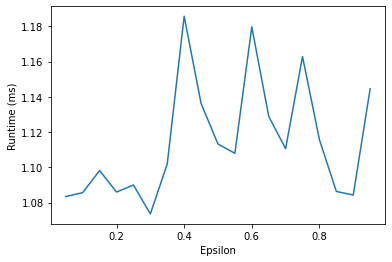

In [ ]:
for eps in epsilons:
  print("Epsilon: {}\t Run-time: {} ms".format(eps, dictRuntimeMeasurement_org[eps]*1000))

lists = sorted(dictRuntimeMeasurement_org.items()) 
x, y = zip(*lists)
y1 = [element * 1000 for element in y]

plt.plot(x,y1)
plt.xlabel("Epsilon")
plt.ylabel("Runtime (ms)")

plt.show()

Q: Does the attack require white-box access to the model?

A: Yes, the FGSM attack requires white-box access to the model. FGSM attack computes the gradient of the loss function and aims at maximizing the loss function. To be able to compute the gradient of the loss functions, a white box access to the model or more percisely the loss function is required. Typically while training a model one would do the opposite by computing the gradient with respect to the training parameters and aim at reducing the loss. 


# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [ ]:
defendedModel = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate_2,momentum=momentum_2)

Training the defense model with the Epsilon value of 0.15 (middle budget)

In [ ]:
adv_train_acc_1=[]
adv_train_losses_1=[]
adv_train_counter_1=[]
adv_test_counter_1=[]
dictPerturbedImage_adv = {}

def adv_training_1(epoch):

  network.train()
  correct = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()

    #Newly computing perturbations and adding them to training data before training the model
    delta = torch.zeros_like(data, requires_grad=True)
    loss =  F.nll_loss(network(data + delta), target)
    loss.backward()
    perturbation= epsilon3Fild[EPSILON_MIDDLE_BUDGET_IDX]*delta.grad.detach().sign()    #Epsilon chosen for middle budget
    adv_train_perturbed_data= data + perturbation
  
    
    #training the network using the pertubated data and computing the loss using negative log-likelihood and
    #computing the training accuracy at the end.
    adv_train_output = network(adv_train_perturbed_data)
    adv_train_loss = F.nll_loss(adv_train_output, target)
    adv_train_loss.backward()
    optimizer.step()
    pred = adv_train_output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
    
    if batch_idx % log_interval == 0:
      adv_train_losses_1.append(adv_train_loss.item())
      adv_train_counter_1.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), "adv_train_model_1.pth")
      #torch.save(optimizer.state_dict(), "adv_train_model_1.pth")
      torch.save(network.state_dict(), defended_model_path)
      torch.save(optimizer.state_dict(), defended_model_path)
  accuracy = 100 * correct / len(train_loader.dataset)
  acc_FGSM_1= accuracy
  adv_train_acc_1.append(accuracy)
  print('Epoch %d, Train Accuracy: %f' % (epoch, accuracy))

In [ ]:
#initDictPerturbedImage(epsilon3Fild[EPSILON_MIDDLE_BUDGET_IDX], dictPerturbedImage_1)

for epoch in range(0, 3):
  adv_training_1(epoch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, Train Accuracy: 84.444000
Epoch 1, Train Accuracy: 85.391998
Epoch 2, Train Accuracy: 85.956001


## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


In [ ]:

dictPerturbedImage_1 = {}
dictAfterAttackAccuracy_1 = {}
dictRuntimeMeasurement_1 = {}
dictSuccessfulAttack_1 = {}


for eps in epsilons:
  fastGradSignAttack(eps, network, test_loader, dictPerturbedImage_1, dictRuntimeMeasurement_1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


At this point, the dictPerturbedImage_1 would have more than 1000 samples for each value of Epsilon. Though the question asks only for 2 values of Epsilon, we've included all values of epsilon because of the very informative plot that we wanted to have in the bottom to compare the accuracy for the whole range of epsilons in the defended and the undefended models.

In our case the 2 values of Epsilon in the neighbourhood of the defended epsilon value is 0.1 and 0.2.

From the below accuracy computation, we see that the accuracy is about 92.4% for defended model with epsilon 0.1 and 85% for the defended model with epsilon 0.2. However the undefended model had 82.6% and 40.2% respectively. 

In [ ]:
for eps in epsilons:
  initDictPerturbedImage(eps, dictSuccessfulAttack_1)
  fastGradSignAttackAccuracy(eps, network, dictPerturbedImage_1, dictSuccessfulAttack_1, dictAfterAttackAccuracy_1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0.05	Test Accuracy = 94.85520313991725
Epsilon: 0.1	Test Accuracy = 92.47448979591837
Epsilon: 0.15	Test Accuracy = 89.10460428601739
Epsilon: 0.2	Test Accuracy = 85.19579751671442
Epsilon: 0.25	Test Accuracy = 79.85978330146591
Epsilon: 0.3	Test Accuracy = 70.76662071890574
Epsilon: 0.35	Test Accuracy = 58.57158040174302
Epsilon: 0.4	Test Accuracy = 46.10223642172524
Epsilon: 0.45	Test Accuracy = 36.05282777718607
Epsilon: 0.5	Test Accuracy = 26.537561183230473
Epsilon: 0.55	Test Accuracy = 22.144373673036092
Epsilon: 0.6	Test Accuracy = 18.35456475583864
Epsilon: 0.65	Test Accuracy = 14.60101867572156
Epsilon: 0.7	Test Accuracy = 12.74896155075088
Epsilon: 0.75	Test Accuracy = 10.982474774296335
Epsilon: 0.8	Test Accuracy = 10.535828194769296
Epsilon: 0.85	Test Accuracy = 9.75816716164616
Epsilon: 0.9	Test Accuracy = 9.427359490986214
Epsilon: 0.95	Test Accuracy = 9.233875252364253


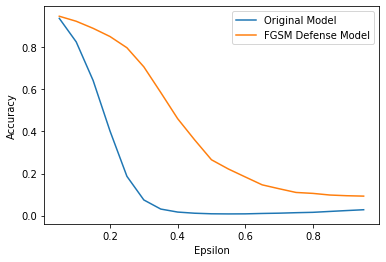

In [ ]:
lists1 = sorted(dictAfterAttackAccuracy_org.items()) 
x1, y1 = zip(*lists1)

lists2 = sorted(dictAfterAttackAccuracy_1.items()) 
x2, y2 = zip(*lists2)

plt.plot(x1,y1, label="Original Model")
plt.plot(x2,y2, label="FGSM Defense Model")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
acc_FGSM1 = dictAfterAttackAccuracy_org[epsilon3Fild[EPSILON_SMALL_BUDGET_IDX]]
acc_FGSM2 = dictAfterAttackAccuracy_org[epsilon3Fild[EPSILON_LARGE_BUDGET_IDX]]

acc_FGSM_defend1=dictAfterAttackAccuracy_1[epsilon3Fild[EPSILON_SMALL_BUDGET_IDX]]
acc_FGSM_defend2=dictAfterAttackAccuracy_1[epsilon3Fild[EPSILON_LARGE_BUDGET_IDX]]

print('Accuracy on the lower-budget adversarial samples (FGSM) %.2f'%acc_FGSM1)
print('Accuracy on the lower-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend1)

print('Accuracy on the higher-budget adversarial samples (FGSM) %.2f'%acc_FGSM2)
print('Accuracy on the higher-budget adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend2)

Accuracy on the lower-budget adversarial samples (FGSM) 0.83
Accuracy on the lower-budget adversarial samples (FGSM) after defense 0.92
Accuracy on the higher-budget adversarial samples (FGSM) 0.40
Accuracy on the higher-budget adversarial samples (FGSM) after defense 0.85


## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

**Answers**

**Q1**

The adversarial training was done using ϵ=0.15.

The defense was more successful against the attack in comparison to the undefended model when the perturbation budget was greater than the perturbation budget of the model on which training was performed $(0.2>0.15>0.01)$. 

We can see a average jump of 45% in the accuracy of model after defense in comparison to the undefended model for perturbation greater than the perturbation budget of the training model. Whereas for the perturbation budget less than the perturbation budget of the model $(0.1<0.15)$ it performed slightly better than the undefended model.

  The results can be summarised as below:

Budget | Undefended Model  | Defended Model 
-------|-------------------|------------------
0.1    |       0.83        |      0.92
0.2    |       0.40        |      0.85




The improvement in the result is due to the adversarial training which   involves training on the perturbations/noise (which basically is result of gradient descent on the input data) which makes the model more aware of the types of attack on the data possible and learns to optimise it accordingly in the training. This training thus helps to improve accuracy during the testing.


**Q2**

The two sets differ to each other in terms of the epsilon(ϵ) which also refers to the percentage of perturbations/noise allowed to be added to the input data image.

It can be oberved that when the noise is less (ϵ=0.1) than perturbation of the trained model(ϵ=0.15) the accuracy of the undefended model and defended model are close due to less amount of noise added and for noise percentage higher than trained model(ϵ=0.2), it has better accuracy as now the defended model is aware of the kind of noise and optimises itself to provide better classification test result.



# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [ ]:
# This function implements the iterative fgsm attack
def i_fgsm_attack(model, x, y, epsilon, alpha, iteration):
  x_adv = x.detach().clone()
  for step in range(iteration):

    # apply fgsm on the image
    x_adv = fgsm_attack(model, x_adv, y, alpha)

    # clip pixel values of intermediate results after each step to ensure that they are in an epsilon-neighbourhood of the original image
    x_adv = torch.clamp(x_adv, min=max(x-epsilon, 0), max=min(x+epsilon, 1))

  # return the adversarial image
  return x_adv


## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [ ]:
# this function generates 10000 adversarial examples using the model and i-fgsm attack
def generate_adversarial_samples(model, epsilon, alpha, iteration):
    adversarial_samples = []
    for x, y in test_loader:
        x_adv = i_fgsm_attack(model=model, x=x, y=y, epsilon=epsilon, alpha=alpha, iteration=iteration).to(device)
        adversarial_samples.append((x_adv, y)) 
        if len(adversarial_samples) == 10000:
          break
    return adversarial_samples


# compute accuracy of the adversarial set on the  model
def compute_accuracy(model, adversarial_set):
    correct = 0
    for x_adv, y in adversarial_set:
        output = model(x_adv)
        y_pred = output.data.max(1, keepdim=True)[1]
      
        if y_pred.item() == y.item():
            correct += 1

    accuracy = correct / 100
    return accuracy
   

In [ ]:
epsilon = 0.2
alpha = 1                                             # from the paper
iteration =  int(min(epsilon + 4, 1.25 * epsilon))    # from the paper

# load the undefended model
undefended_model = Net().to(device)
undefended_model.load_state_dict(torch.load(undefended_model_path))
undefended_model.eval()


FileNotFoundError: ignored

In [ ]:
# attack the undefended model and compute its accuracy
adversarial_samples = generate_adversarial_samples(model=undefended_model, epsilon=epsilon, alpha=alpha, iteration=iteration)
undefended_model_accuracy = compute_accuracy(undefended_model, adversarial_samples)
print("Accuracy of the adversarial set on the undefended model is {}%".format(undefended_model_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the adversarial set on the undefended model is 96.63%


### 3.2.1: Findings and comparison with FGSM (8 points)

* Please report your findings. How successful was the attack? 

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) 

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations. 

**Your answers go here**

## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [ ]:
# load the defended model
defended_model = Net().to(device)
defended_model.load_state_dict(torch.load(defended_model_path))
defended_model.eval()

# attack the defended model
adversarial_samples = generate_adversarial_samples(model=defended_model, epsilon=epsilon, alpha=alpha, iteration=iteration)

# compute how good was the attack
defended_model_accuracy = compute_accuracy(defended_model, adversarial_samples)
print("Accuracy of the adversarial set on the defended model is {}%".format(defended_model_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the adversarial set on the defended model is 97.15%


### 3.3.1: Discussion (7 points) 
* Please report your results. How successful was the attack on the defended model? 
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference? 
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

**Your answers go here**